In [1]:
# Copyright (C) 2023 Jan Mašek and Miroslav Vořechovský
# MIT licence https://en.wikipedia.org/wiki/MIT_License

from SampleTiler import strat_sample_by_tiling, get_LHS_median_sample, get_scrambled_Halton_sample
from Tools import eval_function
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import qmc

A numerical integration example comparing the performance of selected sampling methods:

### Methods:
 Selected are couple of standard sampling methods:
 * Simple Random Sampling (Monte Carlo)
 * LHS with random coordinate pairing, points at strata median
 * Randomized Quasi Monte Carlo (RQMC) - Scrambled Halton Sequence
 
To be compared with the tiled point sets. Selected are:
 * Crude tiling with a single SRS tile 
 * Crude tiling with a single LHS tile 
 * Scrambled tiling with a single LHS tile (small t-shifts only) 
 
Feel free to explore the properties of tiled point sets for various parameter values!

### Function:   &nbsp;&nbsp;&nbsp;&nbsp;   $g_{\Pi\mathrm{exp}} (\mathbf{X}) =    \prod_{v=1}^{N_{\mathrm{v}}}    \exp(-X_v^2)$


Following statistics are computed from the average of $n_r$ realizations of each point sample for a given point count.
 * Estimated mean value
 * Standard deviation
 * Variance
 * Root mean square error
 
 

In [2]:
# The number of points within each tile
ns = 8
# The dimension of the design domain
nv = 2
# Maximum sample size
Ns_max = 1000
# Number of realizations for each sample
nr = 500
# Tile counts
t_max = int((Ns_max / ns) ** (1 / nv)) + 1
t_values = np.arange(1, t_max+1)
# Total point counts
Ns_values = ns*t_values**nv

### Selected sampling methods
sampling_methods = []
# Simple Random Sampling (Monte Carlo)
sampling_methods.append({"name" : "SRS"        , "color" : "blue"  , "dash" : "solid"})
# LHS random pairing, points at strata median
sampling_methods.append({"name" : "LHS-M-R"    , "color" : "red"   , "dash" : "solid"})
# Scrambled Halton sequence
sampling_methods.append({"name" : "RQMC Halton", "color" : "black" , "dash" : "solid"})
# Crude tiling with a single SRS tile 
sampling_methods.append({"name" : "TC/SRS"     , "color" : "blue"  , "dash" : "dashed"})
# Crude tiling with a single LHS tile 
sampling_methods.append({"name" : "TC/LHS-M-R" , "color" : "red"   , "dash" : "dashed"})
# Scrambled tiling with a single LHS tile (small t-shifts only) 
sampling_methods.append({"name" : "TP/LHS-M-R" , "color" : "red"   , "dash" : "dashdot"})

#Function exact solution
exact_solution = 1/np.sqrt(3**nv)

In [3]:
for method in sampling_methods:
    method["results"] = np.zeros([Ns_values.shape[0],nr])
    method["stats"] = np.zeros([Ns_values.shape[0],4])
    
    for idx, t in enumerate (t_values):
        for r in range(nr):
            #Sample generation
            if method["name"] == "SRS":
                 x = np.random.rand(Ns_values[idx],nv)
            if method["name"] == "LHS-M-R":
                 x = get_LHS_median_sample (Ns_values[idx], nv)
            if method["name"] == "RQMC Halton":
                sampler = qmc.Halton(d=nv, scramble=True)
                x = sampler.random(n=Ns_values[idx])
            if method["name"] == "TC/SRS":
                x = strat_sample_by_tiling(nv, ns, t, tile_type = 'SRS', median = True, my_tile = None, one_tile = True,\
                                           var_perms = False, rand_revers = False, t_shifts = True, b_shifts = False,\
                                           large_shifts = False)
            if method["name"] == "TC/LHS-M-R":
                x = strat_sample_by_tiling(nv, ns, t, tile_type = 'LH', median = True, my_tile = None, one_tile = True,\
                                           var_perms = False, rand_revers = False, t_shifts = False, b_shifts = False,\
                                           large_shifts = False)
            if method["name"] == "TP/LHS-M-R":
                x = strat_sample_by_tiling(nv, ns, t, tile_type = 'LH', median = True, my_tile = None, one_tile = True,\
                                           var_perms = False, rand_revers = False, t_shifts = True, b_shifts = False,\
                                           large_shifts = False)
            
            #Function computation
            method["results"][idx,r] = np.mean(eval_function(x))
        
        #Statistical evaluation
        #Mean
        method["stats"][idx,0] = np.mean(method["results"][idx])
        #Standard deviation
        method["stats"][idx,1] = np.std(method["results"][idx])
        #Variance
        method["stats"][idx,2] = method["stats"][idx,1]**2
        #Root mean square error
        method["stats"][idx,3] = np.sqrt( np.mean( (method["results"][idx]-exact_solution)**2) )           

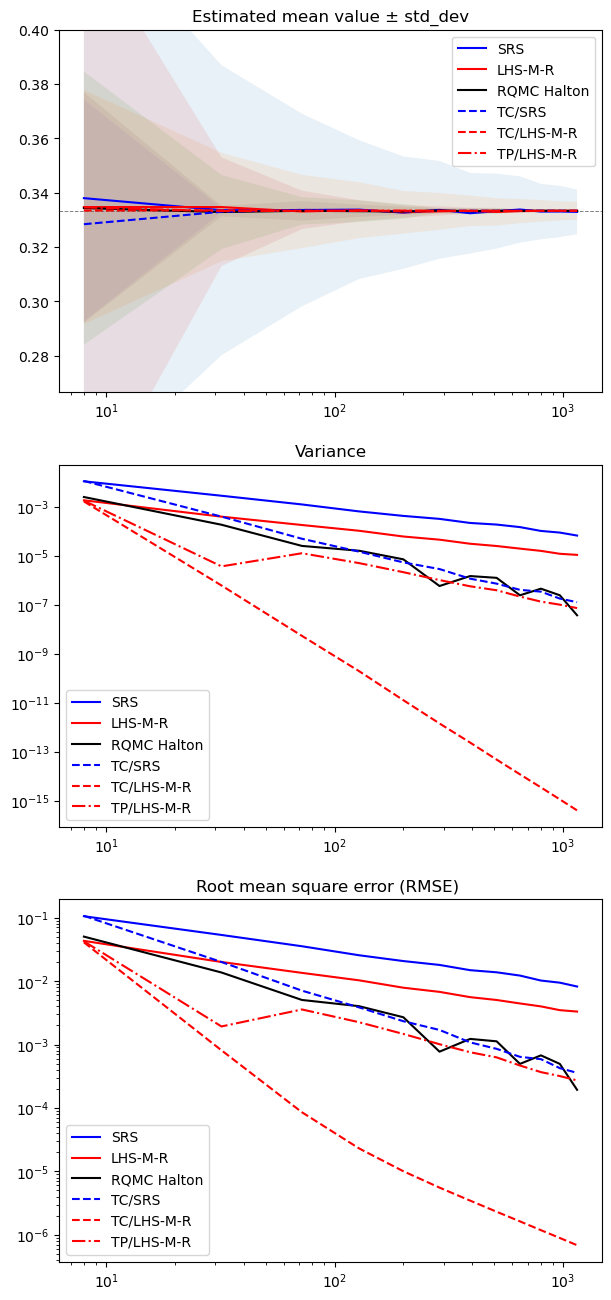

In [4]:
fig, ( pMean, pVar, pRMSE ) = plt.subplots(nrows=3, ncols=1, figsize=(7, 16))

for m in sampling_methods:
    pMean.semilogx(Ns_values, m["stats"][:,0], label=m["name"], color = m["color"], linestyle = m["dash"])
    pMean.fill_between(Ns_values, m["stats"][:,0]+m["stats"][:,1], y2=m["stats"][:,0]-m["stats"][:,1], alpha=0.1)
    
    pVar.loglog(Ns_values, m["stats"][:,2], label=m["name"], color = m["color"], linestyle = m["dash"])
    pRMSE.loglog(Ns_values, m["stats"][:,3], label=m["name"], color = m["color"], linestyle = m["dash"])

pMean.axhline(y=exact_solution, color='gray', linestyle='--', linewidth=0.7, zorder=0)
pMean.set_ylim(exact_solution*0.8,exact_solution*1.2)    
pMean.set_title("Estimated mean value ± std_dev")
pMean.legend()

pVar.set_title("Variance")
pVar.legend()

pRMSE.set_title("Root mean square error (RMSE) ")
pRMSE.legend()
plt.show()